Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at medkit/CamemBert-Bio-Generalized and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-fa33e9e01a68>:80: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.524700,0.465555
2,0.465300,0.480738
3,0.303500,0.432816



Rapport de classification pour l'ensemble de validation :
              precision    recall  f1-score   support

     medecin       0.83      0.86      0.85       234
     patient       0.85      0.82      0.84       226

    accuracy                           0.84       460
   macro avg       0.84      0.84      0.84       460
weighted avg       0.84      0.84      0.84       460



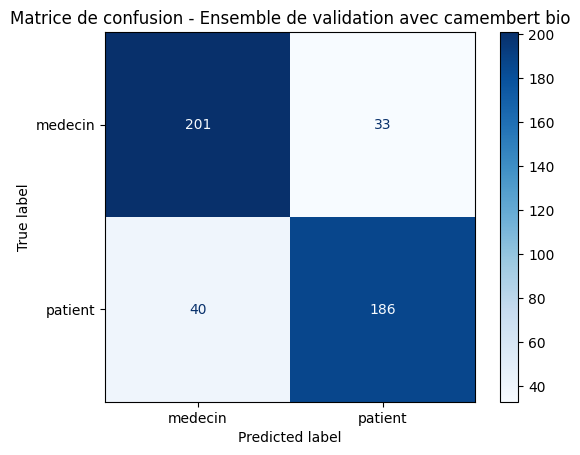

In [9]:
import pandas as pd
from transformers import CamembertTokenizer, CamembertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import re
import os
import numpy as np
os.environ["WANDB_DISABLED"] = "true"

# Chargement des données
data_file = '/content/global_table.tsv'
df = pd.read_csv(data_file, sep="\t")
df = df.dropna(subset=['text', 'speaker'])
df.loc[(df['speaker'] == 'patient_1') | (df['speaker'] == 'patient_2'), 'speaker'] = 'patient'
df['text'] = df['text'].apply(lambda text: re.sub(r'\d+', '', re.sub(r'[^\w\s]', '', text.lower())))

# Encodage des étiquettes
label_encoder = LabelEncoder()
df['speaker_encoded'] = label_encoder.fit_transform(df['speaker'])

# Séparation des ensembles : train, validation, test (70%/15%/15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'], df['speaker_encoded'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

# Chargement du tokenizer
tokenizer = CamembertTokenizer.from_pretrained('medkit/CamemBert-Bio-Generalized')

# Encodage des textes
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Création de la classe Dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Création des datasets
train_dataset = Dataset(train_encodings, list(y_train))
val_dataset = Dataset(val_encodings, list(y_val))
test_dataset = Dataset(test_encodings, list(y_test))

# Chargement du modèle
model = CamembertForSequenceClassification.from_pretrained(
    'medkit/CamemBert-Bio-Generalized',
    num_labels=len(label_encoder.classes_)
)

# Configuration des arguments d'entraînement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False)

# Création du Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer)

# Entraînement
trainer.train()

# Évaluation sur l'ensemble de validation
val_predictions = trainer.predict(val_dataset)

# Extraire les logits et les labels réels
val_logits = val_predictions.predictions
val_labels = val_predictions.label_ids

# Convertir les logits en prédictions de classes
val_preds = np.argmax(val_logits, axis=1)

# Décoder les étiquettes pour affichage dans le rapport de classification
val_labels_decoded = label_encoder.inverse_transform(val_labels)
val_preds_decoded = label_encoder.inverse_transform(val_preds)

# Afficher le rapport de classification
print("\nRapport de classification pour l'ensemble de validation :")
print(classification_report(val_labels_decoded, val_preds_decoded, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(val_labels_decoded, val_preds_decoded, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Ensemble de validation avec camembert bio")
plt.show()


Rapport de classification pour l'ensemble de test :
              precision    recall  f1-score   support

     medecin       0.86      0.85      0.86       244
     patient       0.83      0.85      0.84       216

    accuracy                           0.85       460
   macro avg       0.85      0.85      0.85       460
weighted avg       0.85      0.85      0.85       460



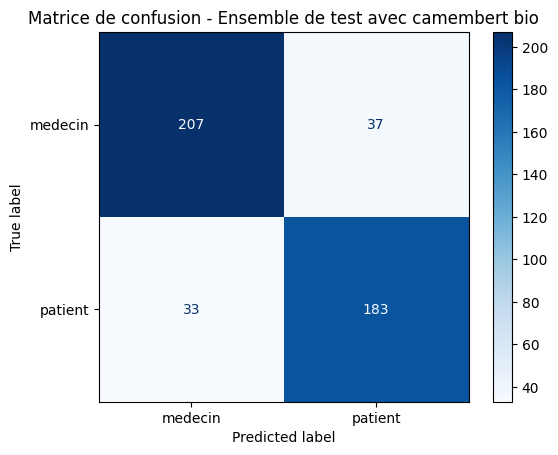

In [10]:
# Faire des prédictions sur l'ensemble de test
test_predictions = trainer.predict(test_dataset)

# Extraire les logits et les labels réels
test_logits = test_predictions.predictions
test_labels = test_predictions.label_ids

# Convertir les logits en prédictions de classes
test_preds = np.argmax(test_logits, axis=1)

# Décoder les étiquettes pour affichage dans le rapport de classification
test_labels_decoded = label_encoder.inverse_transform(test_labels)
test_preds_decoded = label_encoder.inverse_transform(test_preds)

# Afficher le rapport de classification
print("\nRapport de classification pour l'ensemble de test :")
print(classification_report(test_labels_decoded, test_preds_decoded, target_names=label_encoder.classes_))

# Matrice de confusion
cm = confusion_matrix(test_labels_decoded, test_preds_decoded, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice de confusion - Ensemble de test avec camembert bio")
plt.show()

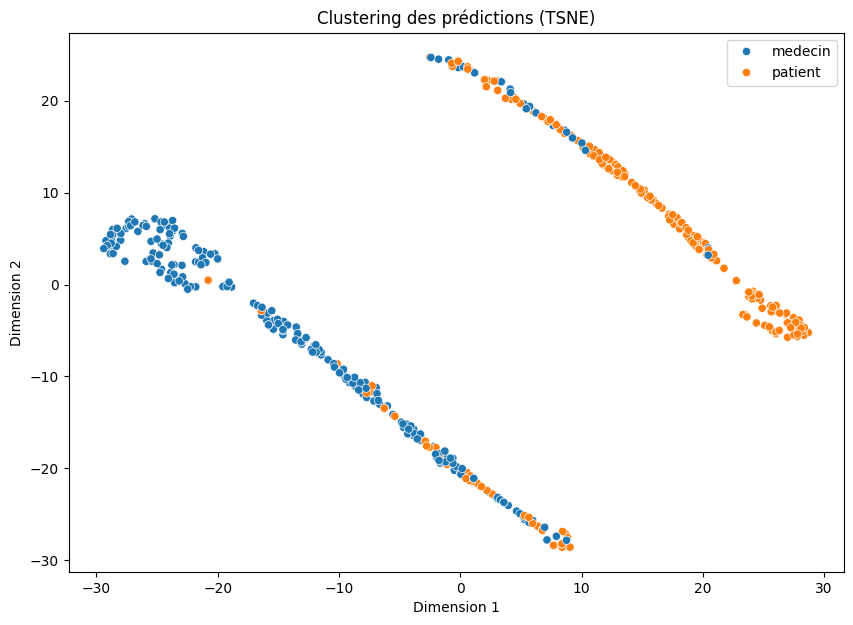

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

features = test_predictions.predictions
labels = test_predictions.label_ids

# Réduction de dimension avec PCA et TSNE
n_samples, n_features = features.shape
n_components_pca = min(n_samples, n_features, 50)
pca = PCA(n_components=n_components_pca)
features_pca = pca.fit_transform(features)

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_pca)

# Créer un DataFrame pour la visualisation
df_tsne = pd.DataFrame(features_tsne, columns=["Dimension 1", "Dimension 2"])
df_tsne["Speaker"] = label_encoder.inverse_transform(labels)  # Décoder les labels pour l'affichage

# Visualisation avec Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_tsne, x="Dimension 1", y="Dimension 2", hue="Speaker", palette="tab10")
plt.title("Clustering des prédictions (TSNE)")
plt.legend(loc="best")
plt.show()